In [1]:
import os
import random

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from xgboost import plot_importance, plot_tree

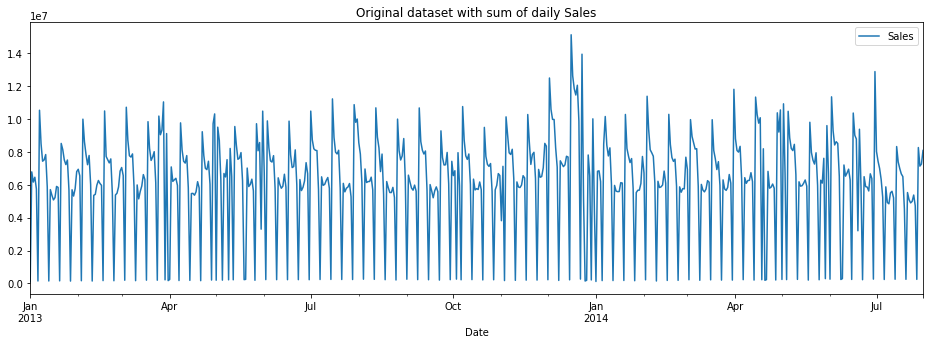

In [3]:
df = pd.read_pickle('clean_data.pkl')

main_df = pd.DataFrame(df.groupby(df['Date'])['Sales'].sum())

main_df.plot(figsize=(16,5))
plt.title('Original dataset with sum of daily Sales')
plt.show()

In [5]:
df.var(axis=0)

Store                        1.036103e+05
DayOfWeek                    3.989725e+00
Sales                        1.460028e+07
Customers                    2.159790e+05
Open                         1.416491e-01
Promo                        2.332164e-01
SchoolHoliday                1.427943e-01
CompetitionDistance          5.888299e+07
CompetitionOpenSinceMonth    1.543025e+01
CompetitionOpenSinceYear     2.978326e+01
Promo2                       2.499187e-01
Promo2SinceWeek              1.993548e+02
Promo2SinceYear              2.789813e+00
dtype: float64

In [ ]:
def train_val_split():
    #read in pickle
    file_path = '../data/clean_data.pkl'
    df = pd.read_pickle(file_path)
    
    #sort dataframe by Store ID
    df.sort_values(by=['Date', 'Store'], ascending=True, inplace=True, ignore_index=True)
    
    #split dataset into features and target
    #k = int(df.shape[0] * relative_train)
    k = df[df['Date'] == '2014-01-31'].index.max()
    data_train = df.loc[:k, :]
    data_val = df.loc[k+1:, :]
    
    assert data_train['Date'].max() < data_val['Date'].min()
    
    #returns train and validation datasets
    return data_train, data_val

In [ ]:
data_train, data_val = train_val_split()

In [ ]:
def feature_engineering(df):
    #compute average sales per customer
    #df.loc[(df['Sales']<=0) | (df['Sales'].isna()), 'sales_per_customer'] = 0
    #df.loc[df['Sales']>0, 'sales_per_customer'] = df['Sales'] / df['Customers']
        
    #convert state holiday categories into yes(=1) and no(=0)
    df.loc[df['StateHoliday'].isin(['a', 'b', 'c']), 'state_holiday'] = 1
    df.loc[~df['StateHoliday'].isin(['a', 'b', 'c']), 'state_holiday'] = 0
    df.drop(['StateHoliday'], axis=1, inplace=True)
    
    #One hot encoding for store type, assortment
    cols = ['StoreType', 'Assortment']
    for col in cols:
        dummies = pd.get_dummies(df[col],prefix=col)
        df = pd.concat([df,dummies],axis=1)
        df.drop(col, axis=1, inplace=True)
    
    #convert Competition month-year into datetime
    df['D'] = 1.0     #helper column for day to be added to date
    df['Competition_open_since'] = pd.to_datetime(df.CompetitionOpenSinceYear*10000+df.CompetitionOpenSinceMonth*100+df.D, format='%Y%m%d')
    
    #determine whether Competition was active at the point in time
    comp = df['Competition_open_since'] <= df['Date']
    df.loc[comp, 'competition_active'] = 1
    df.loc[~comp, 'competition_active'] = 0
     
    
    #convert Promo 2 week-year into datetime
    df['helper_date'] = df.Promo2SinceYear * 1000 + df.Promo2SinceWeek * 10 + 0
    df['Promo_since'] = pd.to_datetime(df['helper_date'], format='%Y%W%w')
    
    #determine whether Promo2 was active during the month
    months = {'Jan': 1, 'Feb': 2, 'Mar': 3, 'Apr': 4, 'May': 5, 'Jun': 6, 'Jul': 7, 'Aug': 8, 'Sep': 9, 'Oct': 10, 'Nov': 11, 'Dec': 12}
    promo_start_later = df['Promo_since'] > df['Date']

    for key, value in months.items():
        df.loc[(df['PromoInterval'].str.contains(key)) & (df['Date'].dt.month == value), 'Promo2_active'] = 1
    df.loc[promo_start_later, 'Promo2_active'] = 0
    df['Promo2_active'].fillna(0, inplace=True)
    
    #create date/datetime features
    df['dayofweek'] = df['Date'].dt.dayofweek
    df['quarter'] = df['Date'].dt.quarter
    df['month'] = df['Date'].dt.month
    df['year'] = df['Date'].dt.year
    df['dayofyear'] = df['Date'].dt.dayofyear
    df['dayofmonth'] = df['Date'].dt.day
    df['weekofyear'] = df['Date'].dt.weekofyear
    
    #delete irrelevant columns
    df.drop(['D',
            'helper_date',
            'CompetitionOpenSinceYear',
            'CompetitionOpenSinceMonth',
            'Competition_open_since',
            'Promo2SinceYear',
            'Promo2SinceWeek',
            'Promo2',
            'PromoInterval',
            'Promo_since',
            'DayOfWeek',
            ], axis=1, inplace=True)
    
    
    
    #### DELETE WHEN MATIAS IS DONE WITH DATA CLEANING###
    df = df.dropna()
    #### DELETE WHEN MATIAS IS DONE WITH DATA CLEANING###
    
    
    
    return df

In [ ]:
train_enh = feature_engineering(data_train)

In [ ]:
train_enh

In [ ]:
fig = plt.figure(figsize=(15, 10))
sns.heatmap(train_enh.corr())

In [ ]:
fig = plt.figure(figsize=(15,7.5))

sns.boxplot(x=train_enh['Sales'])
plt.show()

In [ ]:
fig = plt.figure(figsize=(15,7.5))

sns.boxplot(train_enh['dayofmonth'], train_enh['Sales'])
plt.title('Daily Overview for all stores')
plt.show()

In [ ]:
def q1(x):
    return x.quantile(0.25)

def q2(x):
    return x.quantile(0.75)

f = {'Sales': ['mean', 'median', 'std', q1, q2]}

train_stores = train_enh.groupby('Store').agg(f)
train_stores

In [ ]:
train_new = train_enh.merge(train_stores, left_on='Store', right_on=train_stores.index, how='left')
train_new.columns = ['Date', 'Store', 'Sales', 'Customers', 'Open', 'Promo',
                     'SchoolHoliday', 'CompetitionDistance',
                     'state_holiday', 'StoreType_a', 'StoreType_b', 'StoreType_c',
                     'StoreType_d', 'Assortment_a', 'Assortment_b', 'Assortment_c',
                     'competition_active', 'Promo2_active', 'dayofweek', 'quarter',
                     'month', 'year', 'dayofyear', 'dayofmonth', 'weekofyear',
                     'Sales_mean', 'Sales_median', 'Sales_std', 'Sales_q1', 'Sales_q2']

In [ ]:
fig = plt.figure(figsize=(15,7.5))

sns.boxplot(train_enh['month'], train_enh['Sales'])
plt.title('Monthly Overview for all stores')
plt.show()

In [ ]:
random_store = random.randint(1, 1115)
per_store = train_enh[train_enh['Store'] == random_store]

fig = plt.figure(figsize=(15,7.5))

sns.boxplot(per_store['month'], per_store['Sales'])
plt.title('Monthly Overview for store {}'.format(random_store))
plt.show()

In [ ]:
fig = plt.figure(figsize=(15,7.5))

sns.boxplot(train_enh['weekofyear'], train_enh['Sales'])
plt.title('Weekly Overview for all stores')
plt.show()

In [ ]:
val_enh = feature_engineering(data_val)

In [ ]:
train_enh.to_pickle("./train.pkl")
val_enh.to_pickle("./val.pkl")

In [ ]:
###START HERE AGAIN IF SOMETHING GOT STUCK###

train_enh = pd.read_pickle("./train.pkl")
val_enh = pd.read_pickle("./val.pkl")

In [ ]:
def split_dataset(df, label=None):
    mask_0_sales = df['Sales'] != 0    
    df = df.loc[mask_0_sales, :]
    df.set_index('Date', inplace=True)
    X = df
    
    if label:
        X = df.drop(label, axis=1)
        y = df[label]
        return X, y
        #return X.to_numpy(dtype=np.float32), y.to_numpy(dtype=np.float32)
    return X
    #return X.to_numpy(dtype=np.float32)

X_train, y_train = split_dataset(train_enh, label='Sales')
X_test, y_test = split_dataset(val_enh, label='Sales')

In [ ]:
scaler = StandardScaler()
scaled_X_train = scaler.fit_transform(X_train)
scaled_X_test = scaler.transform(X_test)

In [ ]:
def metric(preds, actuals):
    preds = preds.reshape(-1)
    actuals = actuals.reshape(-1)
    assert preds.shape == actuals.shape
    return 100 * np.linalg.norm((actuals - preds) / actuals) / np.sqrt(preds.shape[0])

In [ ]:
#Initialize XGB
xgb_reg = xgb.XGBRegressor()

xgb_reg.fit(scaled_X_train, y_train)
predictions = xgb_reg.predict(scaled_X_test)

print("RMSPE: " + str(metric(predictions, np.array(y_test))))

In [ ]:
_ = plot_importance(xgb_reg, height=1.5)

In [ ]:
for index, col in enumerate(X_train.columns):
    print('f{}: {}'.format(index, col))

In [ ]:
Xy_train = pd.concat([X_train, y_train], axis=1)
Xy_test = pd.concat([X_test, y_test], axis=1)

In [ ]:
Xy_test['Prediction'] = predictions
df_all = pd.concat([Xy_train, Xy_test], sort=False)
df_all.groupby('Date').sum()[['Sales','Prediction']].plot(figsize=(15, 5))